# Siamese Neural Network Trained with Active Learning Methods

This notebook details the process of training a Siamese Neural Network designed to create a fine-tuned embedding space of image vectors. This supervised training method uses Contrastive loss between pairs of images to bring embeddings closer or further apart according to their similarity. 

Due to this expensive labeling domain of similarity between pairs of images, an active learning method is used to find the most informative pairs to label, while minimizing the total number of labels possible in the resources available.

The process was done in the following steps:
1. Initial small random sample of pairs of images were labeled, from [round0.csv](active_learning_labels/round_0.csv), and divided into training and evaluation. 
2. The network is trained on the data of the last round only, for 100 epochs. If a previous network was already trained, the training is continued from a saved checkpoint.
3. The evaluation of the network is done on the evaluation set as a general guide for the learning capacity of the network. The F1 metric was used due to the unbalanced nature of the dataset.
4. The network is used to determine the confidence of the similarity of unlabeled pairs of images. The pairs with the highest confidence were selected for labeling, up to a budget of ~120 pairs.
5. Additionally, the network is used to determine the confidence of the similarity on samples automatically tagged with 0, and added those to the labeled set for the next round as well.
6. Steps 2 until 5 are repeated, for a total of 4 rounds.

The process of the active learning method is logged in this repository. In [active_learning_labels](active_learning_labels) are the labeled pairs of images for each round, and also a blind test set selected independently of the model. In [active_learning_models](active_learning_models) are the checkpoints of the models trained in each round. In [active_learning_results](active_learning_logs) are the logs of the training and evaluation of the models in each round.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

## Train the Model

In [ ]:
# Enter the current round of active learning:
current_round = 3

# Load the data paths for the current round:
base_path = 'active_learning_labels/'
full_data_paths = pd.read_csv(base_path + 'round_' + str(current_round) + '.csv')
data_paths = full_data_paths[['image1_path', 'image2_path', 'similarity']]

In [3]:
# Split the data into training and testing
train_data = data_paths.sample(frac=0.8, random_state=42)
eval_data = data_paths.drop(train_data.index)
print("Train: ", train_data.shape, "Eval: ", eval_data.shape)

Train:  (384, 3) Eval:  (96, 3)


### Load Computer Vision Model

In [4]:
# Load the pretrained CLIP model and processor from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set up the image transformation pipeline
clip_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Define the dataset class
augmentations = transforms.Compose([
    transforms.RandomApply([transforms.RandomResizedCrop(224)], p=0.3),  # 20% chance of random resized crop
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),  # 20% chance of horizontal flip
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.3),  # 20% chance of color jitter
    transforms.ToTensor(),  # Always apply ToTensor
])


In [5]:
class ImageSimilarityDataset(Dataset):
    """
    A custom dataset class for loading and processing image pairs for similarity tasks.
    Attributes:
        dataframe (pd.DataFrame): DataFrame containing image paths and similarity scores.
        transform (callable, optional): A function/transform to apply to the images.
        augmentations (callable, optional): A function/transform to apply augmentations to the images.
        master_path (str): The base path to prepend to image paths.
    Methods:
        __len__():
            Returns the number of samples in the dataset.
        __getitem__(idx):
            Loads and processes the image pair at the given index.
            Args:
                idx (int): Index of the sample to retrieve.
            Returns:
                tuple: A tuple containing:
                    - image1_path (str): Path to the first image.
                    - image2_path (str): Path to the second image.
                    - image1_features (torch.Tensor): CLIP features of the first image.
                    - image2_features (torch.Tensor): CLIP features of the second image.
                    - label (torch.Tensor): Similarity label (1 for similar, 0 for dissimilar).
    """
    
    def __init__(self, dataframe, transform=clip_transform, augmentations=None):
        self.data = dataframe
        self.transform = transform
        self.augmentations = augmentations
        self.master_path = ''

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load images from the paths
        image1_path = self.master_path + self.data.iloc[idx, 0].strip("()")
        image2_path = self.master_path + self.data.iloc[idx, 1].strip("()")
        
        # Load images
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")

        # Apply augmentations if provided
        # if self.augmentations:
        #     image1 = self.augmentations(image1)
        #     image2 = self.augmentations(image2)

        # Apply CLIP transforms if provided (transforms should convert to tensor)
        if self.transform:
            image1 = self.transform(image1)  # Apply transforms including ToTensor
            image2 = self.transform(image2)

        # Get image features using CLIP
        images_features = []
        for img in [image1, image2]:
            image_tensor = img.unsqueeze(0)  # Add batch dimension for processing
            inputs = processor(images=image_tensor, return_tensors="pt")
            with torch.no_grad():
                image_features = model.get_image_features(**inputs)
            images_features.append(image_features.squeeze())  # Ensure it's a 512-dimensional tensor

        # Get similarity score and label (1 for similar, 0 for dissimilar)
        similarity = self.data.iloc[idx, 2]
        label = 0 if similarity < 3 else 1
        
        return image1_path, image2_path, images_features[0], images_features[1], torch.tensor(label, dtype=torch.float32)


In [6]:
# Set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device('cpu')

print(device)

cuda


In [7]:
# Create datasets
train_dataset = ImageSimilarityDataset(train_data, transform=clip_transform, augmentations=None)
eval_dataset = ImageSimilarityDataset(eval_data, transform=clip_transform, augmentations=None)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [8]:
class SiameseNetwork(nn.Module):
    """
    A Siamese Network for comparing two inputs.
    This network processes two input tensors through identical subnetworks and outputs their respective embeddings.
    Methods
    -------
    __init__():
        Initializes the Siamese Network with fully connected layers and ReLU activation.
    forward_one(x):
        Processes a single input tensor through the network to obtain its embedding.
    forward(input1, input2):
        Processes two input tensors through the network and returns their embeddings.
    Parameters
    ----------
    x : torch.Tensor
        A single input tensor to be processed by the network.
    input1 : torch.Tensor
        The first input tensor to be compared.
    input2 : torch.Tensor
        The second input tensor to be compared.
    Returns
    -------
    torch.Tensor
        The embedding of the input tensor from forward_one.
    tuple of torch.Tensor
        The embeddings of the two input tensors from forward.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)  # Keep larger dimension here
        self.relu = nn.ReLU()

    def forward_one(self, x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


In [9]:
# define the loss function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive Loss Module.
    This module computes the contrastive loss, which is used to train models for tasks such as 
    metric learning. The loss encourages the model to output similar 
    embeddings for similar inputs and dissimilar embeddings for dissimilar inputs.
    Args:
        margin (float, optional): The margin value for dissimilar pairs. Default is 1.0.
    Methods:
        forward(x0, x1, y):
            Computes the contrastive loss between two input tensors.
            Args:
                x0 (torch.Tensor): The first input tensor.
                x1 (torch.Tensor): The second input tensor.
                y (torch.Tensor): The binary labels indicating whether the pairs are similar (1) or dissimilar (0).
            Returns:
                torch.Tensor: The computed contrastive loss.
    """
    

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        label = y # ensure binary labels
        euclidean_distance = nn.functional.pairwise_distance(x0, x1)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + # similar
                                (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # dissimilar
        return loss_contrastive
        

In [10]:
def train_siamese_network(model, train_loader, eval_loader, criterion, optimizer, num_epochs):
    """
    Trains a Siamese network model with Contrastive Loss and returns the best model based on F1 score.
    Args:
        model (torch.nn.Module): The Siamese network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        eval_loader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset.
        criterion (callable): Loss function to be used.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        num_epochs (int): Number of epochs to train the model.
    Returns:
        tuple: A tuple containing the trained model and the state dictionary of the best model based on F1 score.
    """
    
    model.train()
    max_f1_score = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        tp, fp, tn, fn = 0, 0, 0, 0
        
        # Iterate over the training data
        for i, (img1_path, img2_path, img1, img2, labels) in tqdm(enumerate(train_loader)):
            # Move tensors to the appropriate device
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Predictions
            dist = F.pairwise_distance(output1, output2)
            predicted = (dist < 1.0).float() # margin of 1.0
            correct += (predicted == labels).sum().item()

            # F1 score
            tp += ((predicted == 1) & (labels == 1)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            tn += ((predicted == 0) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()

        f1 = 2 * tp / (2 * tp + fp + fn)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {correct / len(train_loader.dataset):.2f}, F1 Score: {f1:.2f}")
        
        # Save the model with the best F1 score
        if f1 >= max_f1_score:
            max_f1_score = f1
            best_model = model.state_dict()
            print("Best model updated")
        
        # Evaluate the model
        # if (epoch + 1) % 5 == 0:
        #     model.eval()
        #     correct = 0
        #     with torch.no_grad():
        #         for img1_path, img2_path, img1, img2, labels in eval_loader:
        #             img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        #             output1, output2 = model(img1, img2)
        #             dist = F.pairwise_distance(output1, output2)
        #             predicted = (dist < 1.0).float()
        #             correct += (predicted == labels).sum().item()
        #     eval_acc = correct / len(eval_loader.dataset)
        #     print(f"Evaluation Accuracy: {eval_acc:.2f}")

        #     # Save the model with the best evaluation accuracy
        #     if eval_acc >= max_acc:
        #         max_acc = eval_acc
        #         best_model = model.state_dict()
        #         print("Best model updated")

    return model, best_model

In [ ]:
# Define model:
siamese_net = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.01)
num_epochs = 50

# Start from last trained model:
siamese_net.load_state_dict(torch.load('active_learning_models/net_round3_2_best.pth'))

In [12]:
trained_model, best_f1_trained_model = train_siamese_network(siamese_net, train_loader, eval_loader, criterion, optimizer, num_epochs)

0it [00:00, ?it/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
48it [01:44,  2.17s/it]


Epoch [1/50], Loss: 0.1484, Train Accuracy: 0.79, F1 Score: 0.13
Best model updated


48it [01:05,  1.37s/it]


Epoch [2/50], Loss: 0.1313, Train Accuracy: 0.74, F1 Score: 0.26
Best model updated


48it [01:04,  1.34s/it]


Epoch [3/50], Loss: 0.1042, Train Accuracy: 0.77, F1 Score: 0.29
Best model updated


48it [01:01,  1.29s/it]


Epoch [4/50], Loss: 0.0710, Train Accuracy: 0.73, F1 Score: 0.30
Best model updated


48it [01:03,  1.32s/it]


Epoch [5/50], Loss: 0.0545, Train Accuracy: 0.78, F1 Score: 0.38
Best model updated


48it [01:02,  1.29s/it]


Epoch [6/50], Loss: 0.0481, Train Accuracy: 0.82, F1 Score: 0.40
Best model updated


48it [01:03,  1.32s/it]


Epoch [7/50], Loss: 0.0706, Train Accuracy: 0.77, F1 Score: 0.33


48it [01:03,  1.33s/it]


Epoch [8/50], Loss: 0.0528, Train Accuracy: 0.76, F1 Score: 0.35


48it [01:03,  1.32s/it]


Epoch [9/50], Loss: 0.0480, Train Accuracy: 0.82, F1 Score: 0.41
Best model updated


48it [01:03,  1.31s/it]


Epoch [10/50], Loss: 0.0554, Train Accuracy: 0.81, F1 Score: 0.39


48it [01:02,  1.31s/it]


Epoch [11/50], Loss: 0.0581, Train Accuracy: 0.84, F1 Score: 0.41


48it [01:02,  1.30s/it]


Epoch [12/50], Loss: 0.0343, Train Accuracy: 0.85, F1 Score: 0.45
Best model updated


48it [01:02,  1.31s/it]


Epoch [13/50], Loss: 0.0422, Train Accuracy: 0.83, F1 Score: 0.43


48it [01:03,  1.32s/it]


Epoch [14/50], Loss: 0.0375, Train Accuracy: 0.83, F1 Score: 0.43


48it [01:02,  1.31s/it]


Epoch [15/50], Loss: 0.0280, Train Accuracy: 0.87, F1 Score: 0.51
Best model updated


48it [01:02,  1.30s/it]


Epoch [16/50], Loss: 0.0243, Train Accuracy: 0.88, F1 Score: 0.55
Best model updated


48it [01:03,  1.32s/it]


Epoch [17/50], Loss: 0.0327, Train Accuracy: 0.88, F1 Score: 0.52


48it [01:03,  1.32s/it]


Epoch [18/50], Loss: 0.0397, Train Accuracy: 0.89, F1 Score: 0.52


48it [01:04,  1.34s/it]


Epoch [19/50], Loss: 0.0242, Train Accuracy: 0.90, F1 Score: 0.59
Best model updated


48it [01:02,  1.31s/it]


Epoch [20/50], Loss: 0.0365, Train Accuracy: 0.86, F1 Score: 0.50


48it [01:02,  1.30s/it]


Epoch [21/50], Loss: 0.0475, Train Accuracy: 0.89, F1 Score: 0.51


48it [01:02,  1.29s/it]


Epoch [22/50], Loss: 0.0809, Train Accuracy: 0.90, F1 Score: 0.51


48it [01:02,  1.30s/it]


Epoch [23/50], Loss: 0.0631, Train Accuracy: 0.88, F1 Score: 0.51


48it [01:02,  1.30s/it]


Epoch [24/50], Loss: 0.1349, Train Accuracy: 0.91, F1 Score: 0.49


48it [01:02,  1.31s/it]


Epoch [25/50], Loss: 0.4100, Train Accuracy: 0.90, F1 Score: 0.30


48it [01:03,  1.31s/it]


Epoch [26/50], Loss: 6.9312, Train Accuracy: 0.92, F1 Score: 0.00


48it [01:02,  1.31s/it]


Epoch [27/50], Loss: 14.5368, Train Accuracy: 0.93, F1 Score: 0.00


48it [01:01,  1.29s/it]


Epoch [28/50], Loss: 3.5775, Train Accuracy: 0.93, F1 Score: 0.07


48it [01:02,  1.31s/it]


Epoch [29/50], Loss: 0.2800, Train Accuracy: 0.93, F1 Score: 0.33


48it [01:02,  1.30s/it]


Epoch [30/50], Loss: 0.0604, Train Accuracy: 0.88, F1 Score: 0.47


48it [01:01,  1.29s/it]


Epoch [31/50], Loss: 0.0376, Train Accuracy: 0.86, F1 Score: 0.49


48it [01:01,  1.28s/it]


Epoch [32/50], Loss: 0.0328, Train Accuracy: 0.87, F1 Score: 0.50


48it [01:01,  1.28s/it]


Epoch [33/50], Loss: 0.0267, Train Accuracy: 0.87, F1 Score: 0.53


48it [01:01,  1.28s/it]


Epoch [34/50], Loss: 0.0236, Train Accuracy: 0.88, F1 Score: 0.53


48it [01:03,  1.32s/it]


Epoch [35/50], Loss: 0.0185, Train Accuracy: 0.88, F1 Score: 0.54


48it [01:02,  1.30s/it]


Epoch [36/50], Loss: 0.0160, Train Accuracy: 0.88, F1 Score: 0.54


48it [01:02,  1.29s/it]


Epoch [37/50], Loss: 0.0141, Train Accuracy: 0.90, F1 Score: 0.58


48it [01:02,  1.30s/it]


Epoch [38/50], Loss: 0.0130, Train Accuracy: 0.89, F1 Score: 0.56


48it [01:01,  1.28s/it]


Epoch [39/50], Loss: 0.0122, Train Accuracy: 0.90, F1 Score: 0.60
Best model updated


48it [01:02,  1.31s/it]


Epoch [40/50], Loss: 0.0091, Train Accuracy: 0.91, F1 Score: 0.62
Best model updated


48it [01:03,  1.31s/it]


Epoch [41/50], Loss: 0.0095, Train Accuracy: 0.90, F1 Score: 0.60


48it [01:02,  1.30s/it]


Epoch [42/50], Loss: 0.0085, Train Accuracy: 0.91, F1 Score: 0.62
Best model updated


48it [01:02,  1.29s/it]


Epoch [43/50], Loss: 0.0076, Train Accuracy: 0.90, F1 Score: 0.60


48it [01:04,  1.34s/it]


Epoch [44/50], Loss: 0.0075, Train Accuracy: 0.91, F1 Score: 0.62
Best model updated


48it [01:02,  1.30s/it]


Epoch [45/50], Loss: 0.0071, Train Accuracy: 0.91, F1 Score: 0.62


48it [01:01,  1.29s/it]


Epoch [46/50], Loss: 0.0061, Train Accuracy: 0.91, F1 Score: 0.63
Best model updated


48it [01:02,  1.30s/it]


Epoch [47/50], Loss: 0.0063, Train Accuracy: 0.91, F1 Score: 0.63
Best model updated


48it [01:03,  1.33s/it]


Epoch [48/50], Loss: 0.0059, Train Accuracy: 0.91, F1 Score: 0.62


48it [01:01,  1.28s/it]


Epoch [49/50], Loss: 0.0051, Train Accuracy: 0.92, F1 Score: 0.65
Best model updated


48it [01:01,  1.29s/it]

Epoch [50/50], Loss: 0.0051, Train Accuracy: 0.93, F1 Score: 0.67
Best model updated


In [13]:
# Save the trained model
save_path = 'active_learning_models/net_round4.pth'

if os.path.exists(save_path):
    print("Model already exists")
else:
    torch.save(best_f1_trained_model, 'active_learning_models/net_round4_best.pth')
    torch.save(trained_model.state_dict(), save_path)
    print("Model saved")

Model saved


## Evaluate the Model

In [14]:
# Load the trained model
best_model = SiameseNetwork().to(device)
best_model.load_state_dict(torch.load('active_learning_models/net_round4_best.pth', map_location=torch.device(device)))

# final_model = SiameseNetwork().to(device)
# final_model.load_state_dict(torch.load('active_learning_models/net_round3_2_final.pth', map_location=torch.device(device)))

/tmp/ipykernel_7280/1548265267.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('active_learning_models/net_round4_best.pth', map_lo

<All keys matched successfully>

In [15]:
def test_siamese_network(model, test_loader, loader_name):
    """
    Evaluates a Siamese network on a given test dataset.
    Args:
        model (torch.nn.Module): The Siamese network model to be evaluated.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        loader_name (str): Name of the test dataset loader, used for printing results.
    Returns:
        None
    This function performs the following steps:
        1. Sets the model to evaluation mode.
        2. Iterates over the test dataset and performs a forward pass to get the outputs.
        3. Calculates the Euclidean distance between the outputs of the Siamese network.
        4. Determines predictions based on the distance.
        5. Computes the accuracy of the model on the test dataset.
        6. Computes the F1 score of the model on the test dataset.
        7. Generates and displays a confusion matrix heatmap.
    Note:
        This function assumes that the model and data are compatible with the device (CPU/GPU) being used.
    """

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        # Iterate over the test data
        for i, (img1_path, img2_path, img1, img2, labels) in enumerate(test_loader):
            # Move tensors to the appropriate device
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calculate the euclidean distance between the outputs
            dist = F.pairwise_distance(output1, output2)

            # Get predictions
            predicted = (dist < 1.0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels)
            all_predictions.extend(predicted)

    # accuracy:
    accuracy = correct / total
    print(f"{loader_name} Accuracy: {accuracy:.4f}")

    # f1 score:
    all_labels = [label.cpu().numpy() for label in all_labels]
    all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
    f1 = f1_score(all_labels, all_predictions)
    print(f"{loader_name} F1 Score: {f1:.4f}")

    # confusion matrix:
    matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

Train Accuracy: 0.9167
Train F1 Score: 0.6364


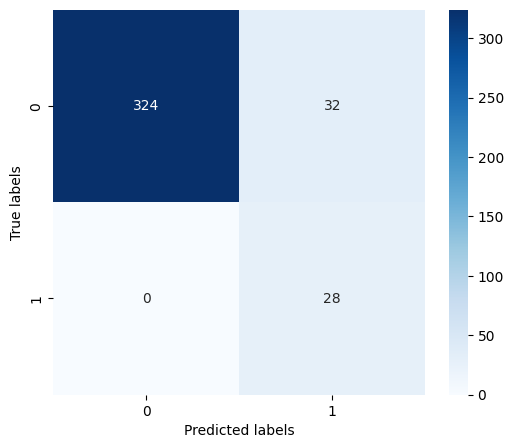

Eval Accuracy: 0.7292
Eval F1 Score: 0.1875


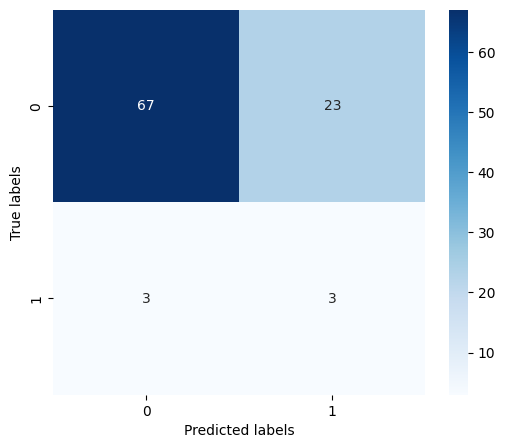

In [16]:
test_siamese_network(best_model, train_loader, "Train")
test_siamese_network(best_model, eval_loader, "Eval")

### Test the model - added in final steps

In [18]:
test_data = pd.read_csv('active_learning_labels/blind_test.csv')
test_data = test_data[['image1_path', 'image2_path', 'similarity']]

test_dataset = ImageSimilarityDataset(test_data, transform=clip_transform, augmentations=None)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Test Accuracy: 0.8767
Test F1 Score: 0.1395


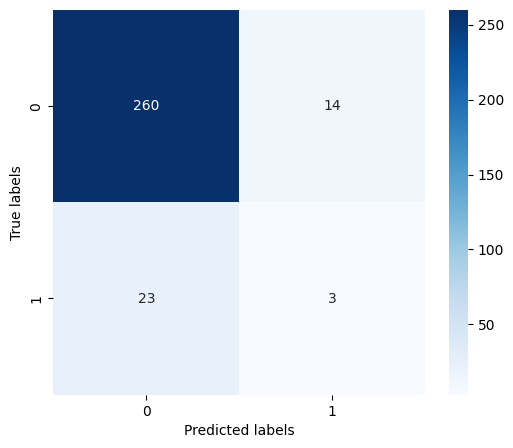

In [19]:
test_siamese_network(best_model, test_loader, "Test")

## Active Learning Setup

In [35]:
# Find the unlabeled data for the next round:
path_data_pool = "datasets/house_styles/sampled_paired_labels_shuffled.csv"
data_pool = pd.read_csv(path_data_pool)
unlabeled_rows = data_pool[data_pool['similarity'].isna()]
print("Unlabeled rows: ", unlabeled_rows.shape)

# Sample 10,000 rows for the next round for feasible runtime:
unlabeled_rows = unlabeled_rows[['image1_path', 'image2_path', 'similarity']].sample(10000)
# Create the dataset for the next round:
unlabeled_dataset = ImageSimilarityDataset(unlabeled_rows, transform=clip_transform)
data_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False)

Unlabeled rows:  (33188, 5)


In [36]:
def active_learning_confident_samples(model, dataloader, margin=1.0, budget=120):
    """
    Selects the least confident samples from a dataloader using an active learning strategy.
    Args:
        model (torch.nn.Module): The model used for generating embeddings.
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of image pairs and labels.
        margin (float, optional): The margin used to calculate confidence scores. Default is 1.0.
        budget (int, optional): The number of least confident samples to return. Default is 120.
    Returns:
        list: A list of tuples containing the paths of the image pairs, their pairwise distance, 
              and their confidence score. The list is sorted in ascending order of confidence score.
    """

    model.eval()
    least_confident_samples = []

    with torch.no_grad():
        # Iterate over the data loader
        for img1_path, img2_path, img1, img2, labels in tqdm(dataloader):
            # Move tensors to the appropriate device
            img1, img2, label = img1.to(device), img2.to(device), labels.to(device)

            # Get the model outputs for both images
            output1, output2 = model(img1, img2)
            
            # Calculate pairwise distance
            distances = F.pairwise_distance(output1, output2)
            
            # Calculate confidence score (distance from the margin)
            confidence_scores = torch.abs(distances - margin)

            # Collect the least confident samples (small confidence score means high uncertainty)
            for i in range(len(confidence_scores)):
                least_confident_samples.append((img1_path[i], img2_path[i], distances[i].item(), confidence_scores[i].item()))

    # Sort samples by confidence score (ascending, to get least confident samples)
    least_confident_samples.sort(key=lambda x: x[3])

    # Return the top_k least confident samples
    return least_confident_samples[:budget]

In [ ]:
least_confident_samples = active_learning_confident_samples(trained_model, data_loader, margin=1.0, budget=120)
# print(least_confident_samples)

In [ ]:
# Find data labeled as 0 automatically for the next round:
zero_rows = data_pool[data_pool['similarity'] == 0]
zero_rows = zero_rows[['image1_path', 'image2_path', 'similarity']].sample(10000)
zero_dataset = ImageSimilarityDataset(zero_rows, transform=clip_transform)
zero_data_loader = DataLoader(zero_dataset, batch_size=8, shuffle=False)

In [ ]:
least_confident_zero = active_learning_confident_samples(trained_model, zero_data_loader, margin=1.0, budget=360)
# print(least_confident_zero)

In [ ]:
# Save the active learning samples to be labeled without a similarity score:
least_confident_samples_df = pd.DataFrame(least_confident_samples, columns=['image1_path', 'image2_path', 'distance', 'confidence'])
least_confident_samples_df['similarity'] = None

# Save the active learning samples with a similarity score of 0:
zero_samples_df = pd.DataFrame(least_confident_zero, columns=['image1_path', 'image2_path', 'distance', 'confidence'])
zero_samples_df['similarity'] = float(0)

In [55]:
### Create a csv for easy labeling:

active_learning_df = pd.concat([least_confident_samples_df, zero_samples_df], ignore_index=True)
# add image names:
active_learning_df['image1'] = active_learning_df['image1_path'].apply(lambda x: x.split('/')[-1])
active_learning_df['image2'] = active_learning_df['image2_path'].apply(lambda x: x.split('/')[-1])
# make paths be surrounded by parentheses:
active_learning_df['image1_path'] = active_learning_df['image1_path'].apply(lambda x: '(' + x + ')')
active_learning_df['image2_path'] = active_learning_df['image2_path'].apply(lambda x: '(' + x + ')')
# shorten distance and confidence:
active_learning_df['distance'] = active_learning_df['distance'].apply(lambda x: round(x, 4))
active_learning_df['confidence'] = active_learning_df['confidence'].apply(lambda x: round(x, 4))

# reorder columns:
active_learning_df = active_learning_df[['image1', 'image1_path', 'image2', 'image2_path', 'distance', 'confidence', 'similarity']]

In [60]:
# Save the active learning samples to a csv file:
result_active_learning_path = 'active_learning_labels/round_2.csv'

if os.path.exists(result_active_learning_path):
    print("File exists")
else:
    print("File does not exist")
    active_learning_df.to_csv(result_active_learning_path, index=False)
    print("File saved")

File does not exist
File saved
